In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xskillscore
from defs import trim_axs, amocstrength, corsst, pvalmask, lon180, makedz, amocstrength_100yr, merid_gradient
import matplotlib as mpl
import gsw
import scipy

In [2]:
folder = ''
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [3]:
#Compute 100-year mean AMOC strength
amocE = np.zeros(len(modellist))
amocEoi = np.zeros(len(modellist))
    
for i in range(len(modellist)):
    model = modellist[i]    
    amocE[i] = amocstrength_100yr(model, 'E280')
    amocEoi[i] = amocstrength_100yr(model, 'Eoi400')

#Eoi400-E280 AMOC strength anomaly
difamoc = amocEoi-amocE

In [4]:
##Create new arrays that contain zonal mean salinity, potential temperature and potential density for E280 and Eoi400

#Use the depths from IPSL-CM6A to interpolate all other models to
model = 'IPSL-CM6A'
ds = xr.open_dataset(folder+model+'/E280/'+'so_zm_100yr.nc')
a = ds.z.values

dsE280 = xr.Dataset(data_vars = dict(rho=(["model", "z","lat"], np.zeros([len(modellist),len(ds.z), len(ds.lat)])), so=(["model", "z","lat"], np.zeros([len(modellist),len(ds.z), len(ds.lat)])), thetao=(["model", "z","lat"], np.zeros([len(modellist),len(ds.z), len(ds.lat)]))), coords = dict(model = modellist, z = ds.z.values, lat = ds.lat.values))
dsEoi400 = xr.Dataset(data_vars = dict(rho=(["model", "z", "lat"], np.zeros([len(modellist), len(ds.z), len(ds.lat)])),so=(["model", "z","lat"], np.zeros([len(modellist),len(ds.z), len(ds.lat)])),thetao=(["model", "z","lat"], np.zeros([len(modellist),len(ds.z), len(ds.lat)]))), coords = dict(model = modellist, z = ds.z.values, lat = ds.lat.values))

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/'+'so_zm_100yr.nc')
    ds2 = xr.open_dataset(folder+model+'/E280/'+'thetao_zm_100yr.nc')
    dsE280.so[i] = ds1.so.interp(z = a, method='linear')
    dsE280.thetao[i] = ds2.thetao.interp(z = a, method='linear')
    dsE280.rho[i] = gsw.density.rho(dsE280.so[i], dsE280.thetao[i], dsE280.so[i]*0)
    
    ds1 = xr.open_dataset(folder+model+'/Eoi400/'+'so_zm_100yr.nc')
    ds2 = xr.open_dataset(folder+model+'/Eoi400/'+'thetao_zm_100yr.nc')
    dsEoi400.so[i] = ds1.so.interp(z = a, method='linear')
    dsEoi400.thetao[i] = ds2.thetao.interp(z = a, method='linear')
    dsEoi400.rho[i] = gsw.density.rho(dsEoi400.so[i], dsEoi400.thetao[i], dsEoi400.so[i]*0)

In [5]:
#Compute MMM zonal mean salinity, pot temp and pot density for all grid cells where >10 models have data
#[:-1] is to exclude HadGEM3 from MMM
rhozmE = dsE280.rho[:-1].where(dsE280.rho.count(dim='model')>10).mean(dim='model')
sozmE = dsE280.so[:-1].where(dsE280.so.count(dim='model')>10).mean(dim='model')
thetaozmE = dsE280.thetao[:-1].where(dsE280.thetao.count(dim='model')>10).mean(dim='model')

rhozmEoi = dsEoi400.rho[:-1].where(dsEoi400.rho.count(dim='model')>10).mean(dim='model')
sozmEoi = dsEoi400.so[:-1].where(dsEoi400.so.count(dim='model')>10).mean(dim='model')
thetaozmEoi = dsEoi400.thetao[:-1].where(dsEoi400.thetao.count(dim='model')>10).mean(dim='model')

In [6]:
#Compute change in meridional gradients in top 1000 m. Gradient is defined as the difference between the average variable in two boxes from 50-70N and 10-30S
difso = np.zeros(len(modellist))
difrho = np.zeros(len(modellist))
difthetao = np.zeros(len(modellist))

lat_bnds = [50,70,-30,-10]
depth = 1000

for i in range(0,len(modellist)):
    model = modellist[i]
    difrho[i] = merid_gradient(dsEoi400.rho[i], lat_bnds, depth)-merid_gradient(dsE280.rho[i], lat_bnds, depth)
    difso[i] = merid_gradient(dsEoi400.so[i], lat_bnds, depth)-merid_gradient(dsE280.so[i], lat_bnds, depth)
    difthetao[i] = merid_gradient(dsEoi400.thetao[i], lat_bnds, depth)-merid_gradient(dsE280.thetao[i], lat_bnds, depth)

In [7]:
#Compute standard deviation of individual models from MMM Eoi400-E280 depth-averaged zonal mean density, temperature and salinity (excluding HadGEM3)
weights = makedz(dsE280.z) #Use for weighting in depth coordinates
stdrho = (dsEoi400.rho[:-1].where(dsEoi400.z<1000).weighted(weights).mean(dim='z') - dsE280.rho[:-1].where(dsE280.z<1000).weighted(weights).mean(dim='z')).std(dim='model')
stdso = (dsEoi400.so[:-1].where(dsEoi400.z<1000).weighted(weights).mean(dim='z')-dsE280.so[:-1].where(dsE280.z<1000).weighted(weights).mean(dim='z')).std(dim='model')
stdthetao = (dsEoi400.thetao[:-1].where(dsEoi400.z<1000).weighted(weights).mean(dim='z')-dsE280.thetao[:-1].where(dsE280.z<1000).weighted(weights).mean(dim='z')).std(dim='model')

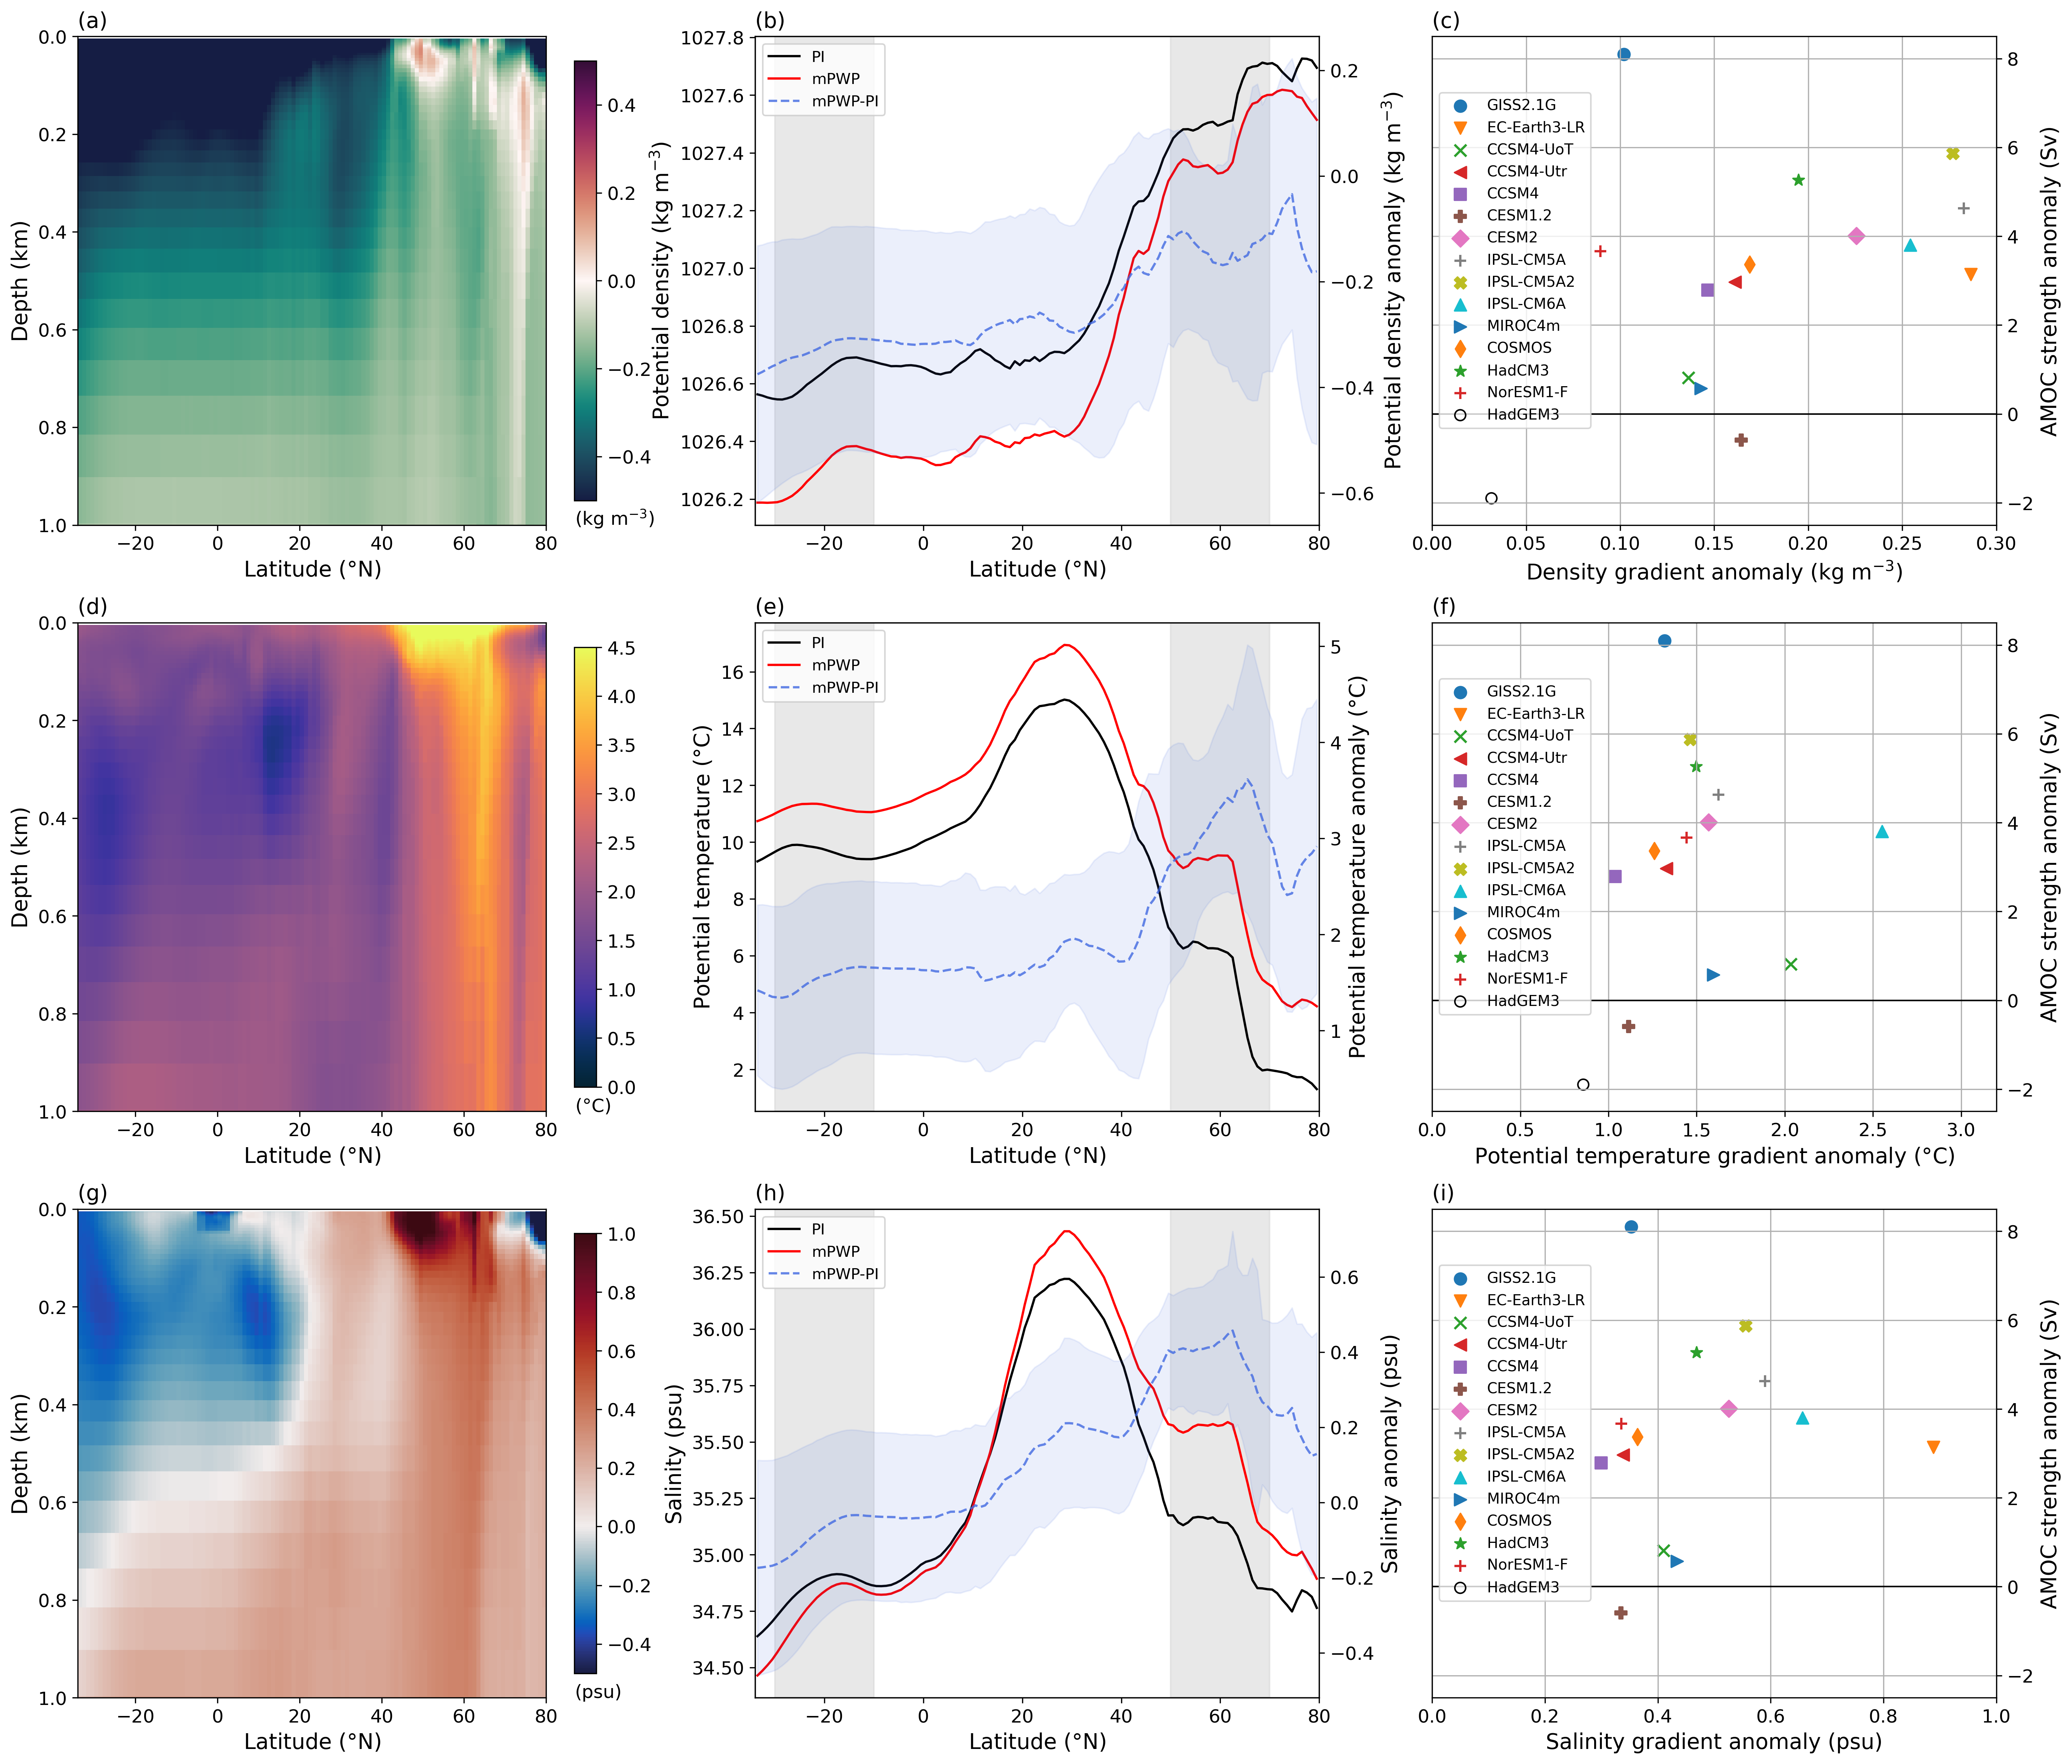

In [18]:
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
fig1, ax = plt.subplots(3, 3, figsize=(22.5,20), dpi=300)

#Plot top 1 km MMM zonal mean pot density, pot temperature and salinity
divnorm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap1 = plt.get_cmap('cmo.curl')

im = ax[0,0].pcolormesh(dsE280.lat, dsE280.z/1000, rhozmEoi-rhozmE, cmap=cmap1, shading='auto', norm=divnorm)
ax[0,0].set_xlabel('Latitude ($\degree$N)')
ax[0,0].set_ylabel('Depth (km)')
ax[0,0].set_xlim([-34,80])
ax[0,0].set_ylim([0,1])
ax[0,0].set_ylim(ax[0,1].get_ylim()[::-1])
cb = fig1.colorbar(im, ax = ax[0,0], orientation='vertical', fraction = 0.12, shrink = 0.9)
#cb.set_label(label = 'Potential density (kg m$^{-3}$)', fontsize=12)
ax[0,0].text(87,1,'(kg m$^{-3}$)', fontsize=12)

divnorm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=1)
cmap1 = plt.get_cmap('cmo.balance')

im = ax[2,0].pcolormesh(dsE280.lat, dsE280.z/1000, sozmEoi-sozmE, cmap=cmap1, shading='auto', norm=divnorm)
ax[2,0].set_xlabel('Latitude ($\degree$N)')
ax[2,0].set_ylabel('Depth (km)')
ax[2,0].set_xlim([-34,80])
ax[2,0].set_ylim([0,1])
ax[2,0].set_ylim(ax[2,1].get_ylim()[::-1])
cb = fig1.colorbar(im, ax = ax[2,0], orientation='vertical', fraction = 0.12, shrink = 0.9)
#cb.set_label(label = 'Salinity (psu)', fontsize=12)
ax[2,0].text(87,1,'(psu)', fontsize=12)

cmap1 = plt.get_cmap('cmo.thermal')

im = ax[1,0].pcolormesh(dsE280.lat, dsE280.z/1000, thetaozmEoi-thetaozmE, cmap=cmap1, shading='auto', vmin=0, vmax = 4.5)
ax[1,0].set_xlabel('Latitude ($\degree$N)')
ax[1,0].set_ylabel('Depth (km)')
ax[1,0].set_xlim([-34,80])
ax[1,0].set_ylim([0,1])
ax[1,0].set_ylim(ax[1,1].get_ylim()[::-1])
cb = fig1.colorbar(im, ax = ax[1,0], orientation='vertical', fraction = 0.12, shrink = 0.9)
#cb.set_label(label = 'Potential temperature ($\degree$ C)', fontsize=12)
ax[1,0].text(87,1,'($\degree$C)', fontsize=12)

#Plot MMM zonal mean depth-averaged (over top 1 km) potential density, potential temperature and salinity, standard deviation by individual models
weights = makedz(rhozmEoi)
rhozmEoi.weighted(weights).mean(dim='z')
lns1 = ax[0,1].plot(rhozmEoi.lat, rhozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'), label='PI', color='black')
lns2 = ax[0,1].plot(rhozmEoi.lat, rhozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'),label='mPWP', color='red')
ax[0,1].set_ylabel('Potential density (kg m$^{-3}$)')
ax2 = ax[0,1].twinx()
lns3 = ax2.plot(rhozmEoi.lat, rhozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z')-rhozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'), label='mPWP-PI', color='royalblue',linestyle='--', linewidth=1.5, alpha=0.8)
ax2.fill_between(rhozmE.lat, (rhozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z')-rhozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'))-stdrho, rhozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z')-rhozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z')+stdrho, color='royalblue', alpha=0.1)
ax2.set_ylabel('Potential density anomaly (kg m$^{-3}$)')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0,1].legend(lns, labs, loc='upper left')

lns1 = ax[2,1].plot(sozmE.lat, sozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'), label='PI', color='black')
lns2 = ax[2,1].plot(sozmE.lat, sozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'),label='mPWP', color='red')
ax[2,1].set_ylabel('Salinity (psu)')
ax2 = ax[2,1].twinx()
lns3 = ax2.plot(sozmE.lat, sozmEoi.where(sozmEoi.z<1000).weighted(weights).mean(dim='z')-sozmE.where(sozmEoi.z<1000).weighted(weights).mean(dim='z'), label='mPWP-PI', color='royalblue',linestyle='--', linewidth=1.5, alpha=0.8)
ax2.fill_between(sozmE.lat, (sozmEoi.where(sozmEoi.z<1000).weighted(weights).mean(dim='z')-sozmE.where(sozmEoi.z<1000).weighted(weights).mean(dim='z'))-stdso, sozmEoi.where(sozmEoi.z<1000).weighted(weights).mean(dim='z')-sozmE.where(sozmEoi.z<1000).weighted(weights).mean(dim='z')+stdso, color='royalblue', alpha=0.1)
ax2.set_ylabel('Salinity anomaly (psu)')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[2,1].legend(lns, labs, loc='upper left')

lns1 = ax[1,1].plot(thetaozmE.lat, thetaozmE.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'), label='PI', color='black')
lns2 = ax[1,1].plot(thetaozmE.lat, thetaozmEoi.where(rhozmEoi.z<1000).weighted(weights).mean(dim='z'), label='mPWP', color='red')
ax[1,1].set_ylabel('Potential temperature ($\degree$C)')
ax2 = ax[1,1].twinx()
lns3 = ax2.plot(thetaozmE.lat, thetaozmEoi.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z')-thetaozmE.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z'), label='mPWP-PI', color='royalblue',linestyle='--', linewidth=1.5, alpha=0.8)
ax2.fill_between(sozmE.lat, (thetaozmEoi.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z')-thetaozmE.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z'))-stdthetao, thetaozmEoi.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z')-thetaozmE.where(thetaozmEoi.z<1000).weighted(weights).mean(dim='z')+stdthetao, color='royalblue', alpha=0.1)
ax2.set_ylabel('Potential temperature anomaly ($\degree$C)')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[1,1].legend(lns, labs, loc='upper left')

for i in range(3):
    ax[i,1].set_xlim([-34,80])
    ax[i,1].set_xlabel('Latitude ($\degree$N)')
    ax[i,1].axvspan(lat_bnds[2],lat_bnds[3], color='lightgrey',alpha=0.5)
    ax[i,1].axvspan(lat_bnds[0],lat_bnds[1], color='lightgrey',alpha=0.5)

#Plot scatter of individual model's meridional density, salinity and temperature gradient anomaly vs AMOC anomaly
for j in range(0,len(modellist)-1):
    scatter = ax[0,2].scatter(difrho[j], difamoc[j], s=60, c = 'C'+str(j), label=modellist[j], marker=markers[j])
    scatter2 = ax[2,2].scatter(difso[j], difamoc[j], s=60, c='C'+str(j), label=modellist[j], marker=markers[j])
    scatter3 = ax[1,2].scatter(difthetao[j], difamoc[j], s=60, c='C'+str(j), label=modellist[j], marker=markers[j])

#Plot HadGEM3 separately with unfilled marker
scatter = ax[0,2].scatter(difrho[-1], difamoc[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
scatter2 = ax[2,2].scatter(difso[-1], difamoc[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
scatter3 = ax[1,2].scatter(difthetao[-1], difamoc[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])

for i in range(0,3):
    ax[i,2].plot([-30, 60], [0, 0], color='black',linewidth =1, linestyle ='-')
    ax[i,2].plot([0, 0], [-50, 150], color='black',linewidth =1, linestyle ='-')
    ax[i,2].yaxis.set_label_position("right")
    ax[i,2].yaxis.tick_right()
    ax[i,2].set_ylim([-2.5, 8.5])
    ax[i,2].set_ylabel('AMOC strength anomaly (Sv)')
    ax[i,2].grid()
    ax[i,2].legend(fontsize=9.7, loc='upper left', bbox_to_anchor=(0,0.9))

ax[0,2].set_xlim([0, 0.3])
ax[2,2].set_xlim([0, 1])
ax[1,2].set_xlim([0, 3.2])

ax[0,2].set_xlabel('Density gradient anomaly (kg m$^{-3}$)')
ax[2,2].set_xlabel('Salinity gradient anomaly (psu)')
ax[1,2].set_xlabel('Potential temperature gradient anomaly ($\degree$C)')

ax[0,0].set_title('(a)', loc='left')
ax[0,1].set_title('(b)', loc='left')
ax[0,2].set_title('(c)', loc='left')
ax[1,0].set_title('(d)', loc='left')
ax[1,1].set_title('(e)', loc='left')
ax[1,2].set_title('(f)', loc='left')
ax[2,0].set_title('(g)', loc='left')
ax[2,1].set_title('(h)', loc='left')
ax[2,2].set_title('(i)', loc='left')

plt.savefig('fig04.png', bbox_inches='tight')